Sources: [https://cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html#Autocorrelation_plots](https://cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html#Autocorrelation_plots)

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures
import json 

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals, calculate_lag_autocorrelation
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import xgboost
import lightgbm
import catboost
import sklearn
import shap
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
    PolynomialFeatures,
)
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import skforecast
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    bayesian_search_forecaster,
    backtesting_forecaster,
)
from skforecast.preprocessing import RollingFeatures
from skforecast.feature_selection import select_features
from skforecast.metrics import calculate_coverage
# ==============================================================================
# Logging model 
import mlflow 
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient


# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version xgboost: {xgboost.__version__}")
print(f"{color}Version catboost: {catboost.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

/home/nhatquang/anaconda3/envs/fsds-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Version skforecast: 0.15.0
Version scikit-learn: 1.6.1
Version lightgbm: 4.6.0
Version xgboost: 3.0.1
Version catboost: 1.2.8
Version pandas: 2.2.3
Version numpy: 1.24.3


In [2]:
# Set up the URI for the MLflow tracking server
mlflow.set_tracking_uri("http://localhost:5000")  # Adjust the URI as needed
# Set the experiment name
mlflow.set_experiment("skforecast_experiment")  # Adjust the experiment name as needed
# Enable autologging for scikit-learn
#mlflow.sklearn.autolog(log_models=True, log_input_examples=True, log_model_signatures=True)

KeyboardInterrupt: 

# Business Understanding

## Statement

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

Bicycle sharing is a popular shared transport service that provides bicycles to individuals for short-term use. These systems typically provide bike docks where riders can borrow a bike and return it to any dock belonging to the same system. The docks are equipped with special bike racks that secure the bike and only release it via computer control. One of the major challenges faced by operators of these systems is the need to redistribute bikes to ensure that there are bikes available at all docks, as well as free spaces for returns.

In order to improve the planning and execution of bicycle distribution, it is proposed to create a model capable of forecasting the number of users over the next 36 hours. In this way, at 12:00 every day, the company in charge of managing the system will be able to know the expected users for the rest of the day (12 hours) and the next day (24 hours).

For illustrative purposes, the current example only models a single station.

# EDA

## Getting data

In [2]:
data = fetch_dataset('bike_sharing', raw=True)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 12)


In [3]:
# Preprocessing data (setting index and frequency)
# ==============================================================================
data = data[['date_time', 'users', 'holiday', 'weather', 'temp', 'atemp', 'hum', 'windspeed']]
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
if pd.__version__ < '2.2':
    data = data.asfreq('H')
else:
    data = data.asfreq('h')
data = data.sort_index()
data.head()

users  holiday weather  temp   atemp   hum  windspeed
date_time                                                                 
2011-01-01 00:00:00   16.0      0.0   clear  9.84  14.395  81.0        0.0
2011-01-01 01:00:00   40.0      0.0   clear  9.02  13.635  80.0        0.0
2011-01-01 02:00:00   32.0      0.0   clear  9.02  13.635  80.0        0.0
2011-01-01 03:00:00   13.0      0.0   clear  9.84  14.395  75.0        0.0
2011-01-01 04:00:00    1.0      0.0   clear  9.84  14.395  75.0        0.0

## Plot time series

In [4]:
# Split data into train, validation, and test sets
# The last 36 records are the test set
test_size = 36
test = data.iloc[-test_size:]
train_val = data.iloc[:-test_size]

# You can set the ratio of train and validation as needed, e.g., 80% train, 20% val
train_ratio = 0.8
train_size = int(len(train_val) * train_ratio)
train = train_val.iloc[:train_size]
val = train_val.iloc[train_size:]

print(f"Train shape: {train.shape}")
print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")

Train shape: (14006, 7)
Validation shape: (3502, 7)
Test shape: (36, 7)


In [5]:
train

users  holiday weather   temp   atemp   hum  windspeed
date_time                                                                  
2011-01-01 00:00:00   16.0      0.0   clear   9.84  14.395  81.0     0.0000
2011-01-01 01:00:00   40.0      0.0   clear   9.02  13.635  80.0     0.0000
2011-01-01 02:00:00   32.0      0.0   clear   9.02  13.635  80.0     0.0000
2011-01-01 03:00:00   13.0      0.0   clear   9.84  14.395  75.0     0.0000
2011-01-01 04:00:00    1.0      0.0   clear   9.84  14.395  75.0     0.0000
...                    ...      ...     ...    ...     ...   ...        ...
2012-08-06 09:00:00  276.0      0.0    rain  28.70  33.335  79.0    11.0014
2012-08-06 10:00:00  213.0      0.0   clear  30.34  34.850  70.0    15.0013
2012-08-06 11:00:00  260.0      0.0   clear  31.16  36.365  66.0     8.9981
2012-08-06 12:00:00  285.0      0.0    mist  31.98  36.365  55.0     6.0032
2012-08-06 13:00:00  289.0      0.0   clear  32.80  37.120  49.0    15.0013

[14006 rows x 7 columns]

In [5]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-04-30 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Dates train      : 2011-01-01 00:00:00 --- 2012-04-30 23:00:00  (n=11664)
Dates validacion : 2012-05-01 00:00:00 --- 2012-08-31 23:00:00  (n=2952)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


In [11]:
data.index[:72]

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               '2011-01-01 10:00:00', '2011-01-01 11:00:00',
               '2011-01-01 12:00:00', '2011-01-01 13:00:00',
               '2011-01-01 14:00:00', '2011-01-01 15:00:00',
               '2011-01-01 16:00:00', '2011-01-01 17:00:00',
               '2011-01-01 18:00:00', '2011-01-01 19:00:00',
               '2011-01-01 20:00:00', '2011-01-01 21:00:00',
               '2011-01-01 22:00:00', '2011-01-01 23:00:00',
               '2011-01-02 00:00:00', '2011-01-02 01:00:00',
               '2011-01-02 02:00:00', '2011-01-02 03:00:00',
               '2011-01-02 04:00:00', '2011-01-02 05:00:00',
               '2011-01-02 06:00:00', '2011-01-02 07:00:00',
               '2011-01-

In [18]:
import os

# Parameters
history_len = 2400
forecast_len = 36
segment_len = history_len + forecast_len
output_dir = "test_splits"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# No reset_index — we keep datetime as index
n_total = len(data_test)
n_splits = (n_total - segment_len) // forecast_len + 1

for i in range(n_splits):
    start_idx = i * forecast_len
    end_idx = start_idx + segment_len

    if end_idx > n_total:
        break  # Prevent overflow

    segment = data_test.iloc[start_idx:end_idx].copy()
    filename = f"test_{i+1}.csv"
    filepath = os.path.join(output_dir, filename)
    
    # Save with datetime index preserved
    segment.to_csv(filepath, index_label="date_time", date_format="%Y-%m-%d %H:%M:%S")
    print(f"Saved: {filepath}")


Saved: test_splits/test_1.csv
Saved: test_splits/test_2.csv
Saved: test_splits/test_3.csv
Saved: test_splits/test_4.csv
Saved: test_splits/test_5.csv
Saved: test_splits/test_6.csv
Saved: test_splits/test_7.csv
Saved: test_splits/test_8.csv
Saved: test_splits/test_9.csv
Saved: test_splits/test_10.csv
Saved: test_splits/test_11.csv
Saved: test_splits/test_12.csv
Saved: test_splits/test_13.csv
Saved: test_splits/test_14.csv


In [7]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['users'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['users'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['users'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Number of users',
    xaxis_title="Time",
    yaxis_title="Users",
    legend_title="Partition:",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

Just zoom in and we see that there are some seasonality inside the time series

## Plot seasonaility

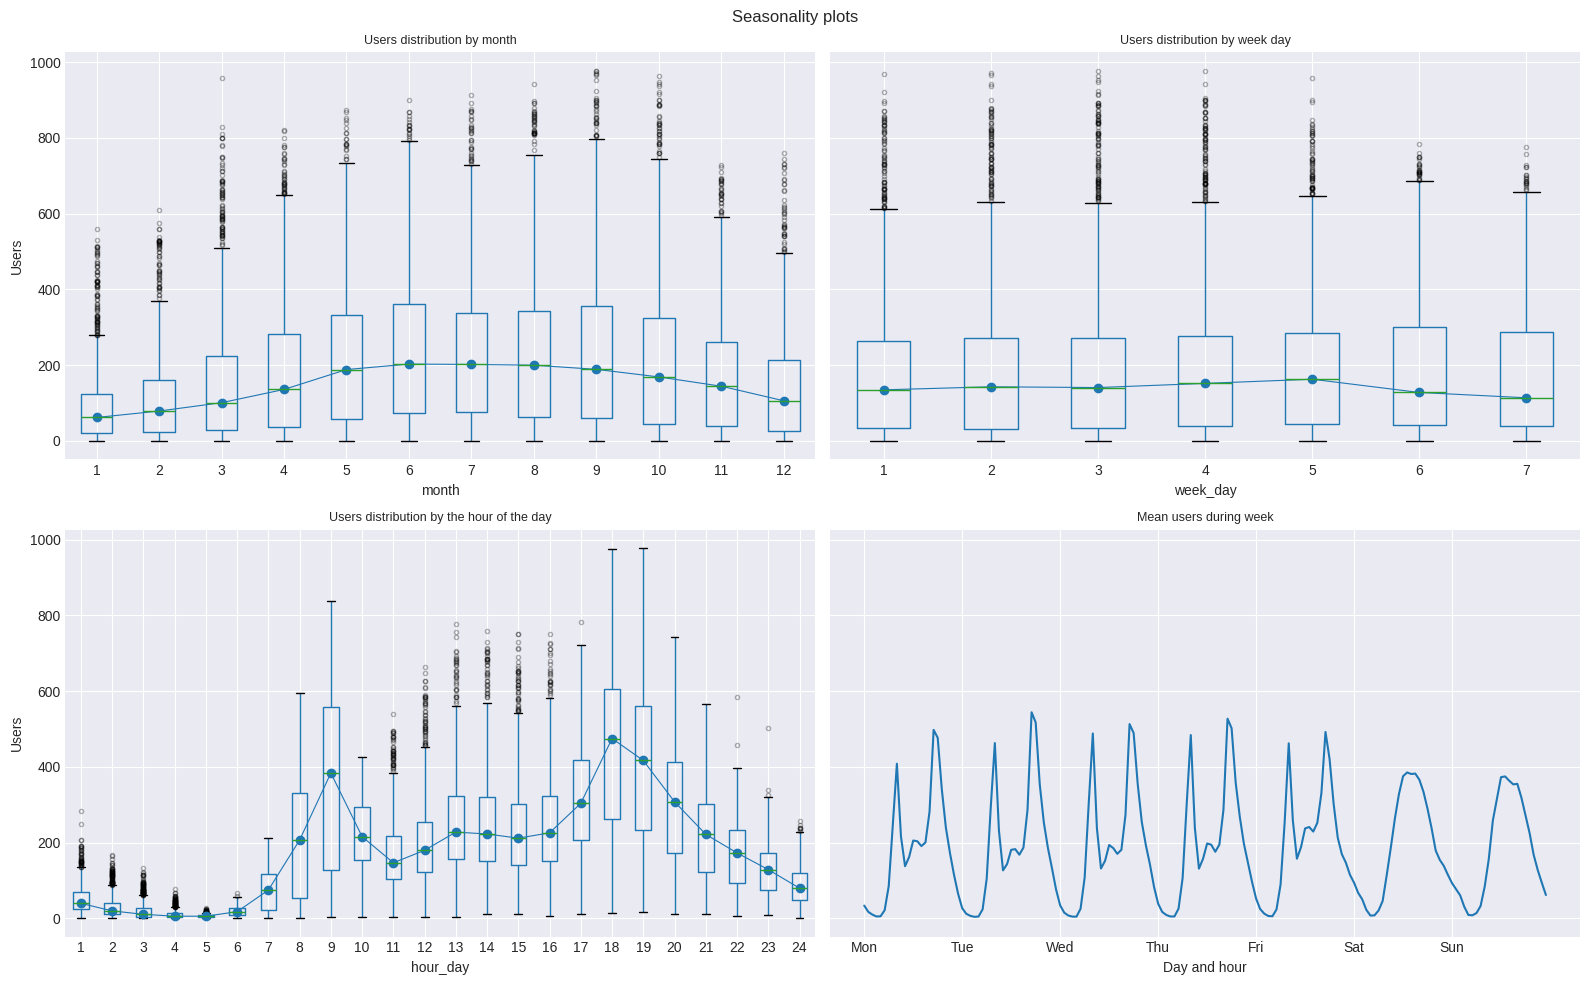

In [8]:
# Annual, weekly and daily seasonality
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=False, sharey=True)
axs = axs.ravel()

# Users distribution by month
data['month'] = data.index.month
data.boxplot(column='users', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Users')
axs[0].set_title('Users distribution by month', fontsize=9)

# Users distribution by week day
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='users', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Users')
axs[1].set_title('Users distribution by week day', fontsize=9)

# Users distribution by the hour of the day
data['hour_day'] = data.index.hour + 1
data.boxplot(column='users', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('hour_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Users')
axs[2].set_title('Users distribution by the hour of the day', fontsize=9)

# Users distribution by week day and hour of the day
mean_day_hour = data.groupby(["week_day", "hour_day"])["users"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean users during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Day and hour",
    ylabel      = "Number of users"
)
axs[3].title.set_size(9)

fig.suptitle("Seasonality plots", fontsize=12)
fig.tight_layout()

## Plot ACF/PACF

Auto-correlation plots are a useful tool for identifying the order of an autoregressive model. The autocorrelation function (ACF) is a measure of the correlation between the time series and a lagged version of itself. The partial autocorrelation function (PACF) is a measure of the correlation between the time series and a lagged version of itself, controlling for the values of the time series at all shorter lags. These plots are useful for identifying the lags to be included in the autoregressive model.

When you look at an ACF plot, you’ll see bars at each lag. The height of the bar represents the correlation coefficient at that lag.

- Significant Lag: If a bar extends beyond the significance bounds, it indicates significant autocorrelation at that lag.
- Gradual Decline: A gradual decline in bar heights suggests a long-term dependency in the data.
- Seasonal Patterns: Regular spikes at certain lags suggest seasonality in the data.



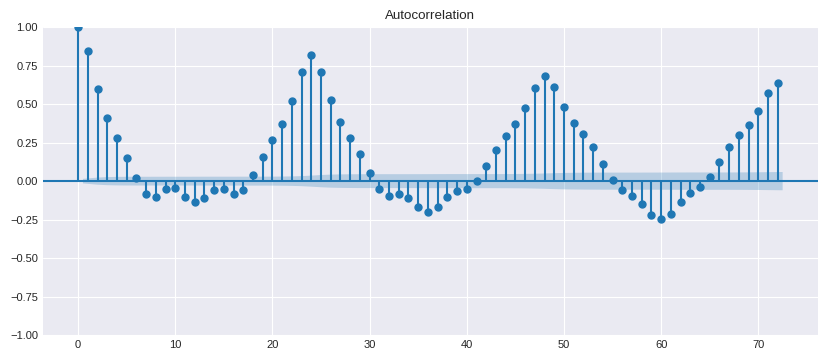

In [190]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(data['users'], ax=ax, lags=72)
plt.show()

The PACF plot helps determine the order of an autoregressive model (AR model).

- Significant Lag: A significant spike at a particular lag suggests the inclusion of that lag in the AR model.
- Cut-off Point: The lag at which the PACF plot cuts off helps determine the maximum lag to include in the AR model.

The ACF plot shows a significant sinusoidal pattern with a periodicity, indicating strong seasonal behavior. The slow decay in the autocorrelations suggests a non-stationary series with periodic fluctuations.

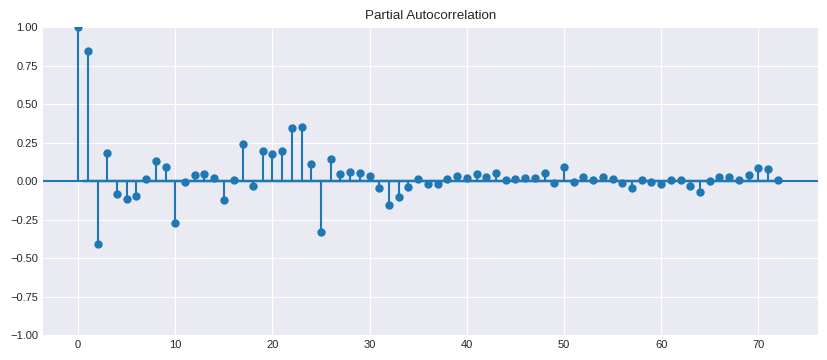

In [191]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(data['users'], ax=ax, lags=72, method='ywm')
plt.show()

In [192]:
# Top 10 lags with highest absolute partial autocorrelation
# ==============================================================================
calculate_lag_autocorrelation(
    data    = data['users'],
    n_lags  = 60,
    sort_by = "partial_autocorrelation_abs"
).head(10)

lag  partial_autocorrelation_abs  partial_autocorrelation  \
0    1                     0.845220                 0.845220   
1    2                     0.408349                -0.408349   
2   23                     0.355669                 0.355669   
3   22                     0.343601                 0.343601   
4   25                     0.332366                -0.332366   
5   10                     0.272649                -0.272649   
6   17                     0.241984                 0.241984   
7   19                     0.199286                 0.199286   
8   21                     0.193404                 0.193404   
9    3                     0.182068                 0.182068   

   autocorrelation_abs  autocorrelation  
0             0.845172         0.845172  
1             0.597704         0.597704  
2             0.708470         0.708470  
3             0.520804         0.520804  
4             0.711256         0.711256  
5             0.046483        -0.046483  
6             0.057267        -0.057267  
7             0.159897         0.159897  
8             0.373666         0.373666  
9             0.409680         0.409680

The results of the autocorrelation study show that there is a significant correlation between the number of users in previous hours, as well as the days before, and the number of users in the future. This means that knowing the number of users during certain periods in the past could be valuable in predicting the number of users in the future.

# Modeling

## Log function into Mlflow

In [193]:
import mlflow.pyfunc
class SkforecastWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, forecaster):
        self.forecaster = forecaster

    def predict(self, context, model_input):
        # Ensure model_input is a pandas Series
        if isinstance(model_input, pd.DataFrame):
            model_input = model_input.squeeze()
        return self.forecaster.predict(steps=len(model_input))

/home/nhatquang/anaconda3/envs/fsds-env/lib/python3.10/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning:

Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.



## Baseline

In short, a simple model that can be used as a reference to assess whether more complicated models are worth implementing. 

Let use the Seasonal naive Forecaasting, which simply returns the value observed in the same period of the previuous season. 

Thanks to the EDA step, we know that there are some seasnonality in day and hour, therefore we will let the forecasting of this hour to be the same as the same hour, but previous day 

In [194]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'users'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Creation date: 2025-05-25 20:22:48 
Last fit date: 2025-05-25 20:22:48 
Skforecast version: 0.15.0 
Python version: 3.10.16 
Forecaster id: None 

In [195]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))
metric_baseline, predictions = backtesting_forecaster(
                                   forecaster = forecaster,
                                   y          = data['users'],
                                   cv         = cv,
                                   metric     = 'mean_absolute_error'
                               )
metric_baseline



100%|██████████| 82/82 [00:00<00:00, 594.98it/s]


mean_absolute_error
0            91.668716

In [196]:

# Start an MLflow run
with mlflow.start_run():
    # Log the baseline metric
    mlflow.log_metric("mae", metric_baseline.values[0])
    mlflow.log_param("offset_days", forecaster.offset.days)
    mlflow.log_param("n_offsets", forecaster.n_offsets)

    # Log the custom model
    mlflow.pyfunc.log_model(
        artifact_path="skforecast_model/baseline",
        python_model=SkforecastWrapper(forecaster),
        registered_model_name="SkforecastEquivalentDateModel"  
    )


2025/05/25 20:22:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SkforecastEquivalentDateModel' already exists. Creating a new version of this model...
2025/05/25 20:22:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SkforecastEquivalentDateModel, version 6


🏃 View run handsome-rat-477 at: http://localhost:5000/#/experiments/485660675930513908/runs/b83b559e60eb481d86dceb47a200d30a
🧪 View experiment at: http://localhost:5000/#/experiments/485660675930513908


Created version '6' of model 'SkforecastEquivalentDateModel'.


## Multi-step processing with LightGBM

LightGBM is a highly efficient implementation of the stochastic gradient boosting algorithm, which has become a benchmark in the field of machine learning. The LightGBM library includes its own API as well as the scikit-learn API, making it compatible with skforecast.

First, an ForecasterRecursive model is trained using past values (lags) and moving average as predictors. Later, exogenous variables are added to the model and the improvement in its performance is assessed. Since Gradient Boosting models have a large number of hyperparameters, a Bayesian Search is performed using the bayesian_search_forecaster() function to find the best combination of hyperparameters and lags. Finally, the predictive ability of the model is evaluated using a backtesting process.


In [219]:
# Create forecaster
# ==============================================================================
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                lags            = 24,
                window_features = window_features
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'users'])
forecaster


=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_72'] 
Window size: 72 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-05-25 22:00:08 
Last fit date: 2025-05-25 22:00:09 
Skforecast version: 0.15.0 
Python version: 3.10.16 
Forecaster id: None

In [225]:
# predict w forecaster
forecaster.predict(steps=36)

2012-09-01 00:00:00    108.331027
2012-09-01 01:00:00     68.562982
2012-09-01 02:00:00     33.499525
2012-09-01 03:00:00     10.027583
2012-09-01 04:00:00      3.037563
2012-09-01 05:00:00     17.162543
2012-09-01 06:00:00     51.059825
2012-09-01 07:00:00    146.940053
2012-09-01 08:00:00    344.320596
2012-09-01 09:00:00    439.738683
2012-09-01 10:00:00    368.890464
2012-09-01 11:00:00    355.700231
2012-09-01 12:00:00    374.760610
2012-09-01 13:00:00    395.340380
2012-09-01 14:00:00    361.946469
2012-09-01 15:00:00    345.408498
2012-09-01 16:00:00    339.746771
2012-09-01 17:00:00    397.174445
2012-09-01 18:00:00    375.910976
2012-09-01 19:00:00    354.345013
2012-09-01 20:00:00    305.802228
2012-09-01 21:00:00    248.215396
2012-09-01 22:00:00    196.169787
2012-09-01 23:00:00    147.019855
2012-09-02 00:00:00    105.701065
2012-09-02 01:00:00     69.842106
2012-09-02 02:00:00     41.532537
2012-09-02 03:00:00     20.335542
2012-09-02 04:00:00     10.169489
2012-09-02 05:

In [220]:
import mlflow.pyfunc

class SkforecastWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, forecaster, steps=36):
        self.forecaster = forecaster
        self.steps = steps

    def predict(self, context, model_input):
        return self.forecaster.predict(steps=self.steps)


/home/nhatquang/anaconda3/envs/fsds-env/lib/python3.10/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning:

Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.



### Back testing

In order to have a robust estimate of the predictive ability of the model, a backtesting process is carried out. The backtesting process consists of generating a forecast for each observation in the test set, following the same procedure as it would be done in production, and then comparing the predicted value with the actual value.

It is highly recommended to review the documentation for the backtesting_forecaster() function to gain a better understanding of its capabilities. This will help to utilize its full potential to analyze the predictive ability of the model.

In [200]:
data_test

users  holiday weather   temp   atemp   hum  windspeed
date_time                                                                  
2012-09-01 00:00:00  168.0      0.0   clear  30.34  34.090  62.0     7.0015
2012-09-01 01:00:00   79.0      0.0   clear  29.52  34.850  74.0     8.9981
2012-09-01 02:00:00   69.0      0.0   clear  28.70  32.575  70.0    11.0014
2012-09-01 03:00:00   35.0      0.0   clear  28.70  32.575  70.0     7.0015
2012-09-01 04:00:00   12.0      0.0   clear  28.70  32.575  70.0     0.0000
...                    ...      ...     ...    ...     ...   ...        ...
2012-12-31 19:00:00  119.0      0.0    mist  10.66  12.880  60.0    11.0014
2012-12-31 20:00:00   89.0      0.0    mist  10.66  12.880  60.0    11.0014
2012-12-31 21:00:00   90.0      0.0   clear  10.66  12.880  60.0    11.0014
2012-12-31 22:00:00   61.0      0.0   clear  10.66  13.635  56.0     8.9981
2012-12-31 23:00:00   49.0      0.0   clear  10.66  13.635  65.0     8.9981

[2928 rows x 7 columns]

In [103]:
# Backtest model on test data
# ==============================================================================
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))
metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['users'],
                          cv         = cv,
                          metric     = 'mean_absolute_error'
                      )
predictions.head()

100%|██████████| 82/82 [00:00<00:00, 131.12it/s]


pred
2012-09-01 00:00:00  108.331027
2012-09-01 01:00:00   68.562982
2012-09-01 02:00:00   33.499525
2012-09-01 03:00:00   10.027583
2012-09-01 04:00:00    3.037563

In [108]:
forecaster.summary()

ForecasterRecursive 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_72'] 
Window size: 72 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation

In [221]:
wrapper = SkforecastWrapper(forecaster, steps=36)
# Start an MLflow run
with mlflow.start_run():
    # Log the baseline metric
    mlflow.set_tags({
        "model_type": "Recursive",
        "regressor": forecaster.regressor.__class__.__name__,
        "feature_engineering": "normal"
    })
    mlflow.log_metric("mae", metric.values[0])
    mlflow.log_param("lags", forecaster.lags)
    mlflow.log_param("window_sizes", forecaster.window_size)
    mlflow.log_param("regressor", forecaster.regressor.__class__.__name__)
    mlflow.log_param("regressor_params", forecaster.regressor.get_params())
    
    # Log the custom model
    mlflow.pyfunc.log_model(
        artifact_path="skforecast_model/recursive",
        python_model=wrapper,
        registered_model_name="SkforecastRecursiveModel"  
    )


2025/05/25 22:09:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SkforecastRecursiveModel' already exists. Creating a new version of this model...
2025/05/25 22:09:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SkforecastRecursiveModel, version 6


🏃 View run zealous-goose-400 at: http://localhost:5000/#/experiments/485660675930513908/runs/187db747f4ad45538d04db59f1a299a2
🧪 View experiment at: http://localhost:5000/#/experiments/485660675930513908


Created version '6' of model 'SkforecastRecursiveModel'.


The prediction error of the autoregressive model achieves a lower MAE than that of the baseline model.

### Exorgenous Variable
So far, only lagged values of the time series have been used as predictors. However, it is possible to include other variables as predictors. These variables are known as exogenous variables (features) and their use can improve the predictive capacity of the model. **A very important point to keep in mind is that the values of the exogenous variables must be known at the time of prediction.**

Common examples of exogenous variables are those derived from the calendar, such as the day of the week, month, year, or holidays. Weather variables such as temperature, humidity, and wind also fall into this category, as do economic variables such as inflation and interest rates.

Next, exogenous variables are created based on calendar information, sunrise and sunset times, temperature, and holidays. **These new variables are then added to the training, validation and test sets, and used as predictors in the autoregressive model.**

In [127]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           ='index',
    features_to_extract = features_to_extract,
    drop_original       = True,
)
calendar_features = calendar_transformer.fit_transform(data)[features_to_extract]

# Sunlight features (the location of the bike sharing station)
# ==============================================================================
location = LocationInfo(
    name      = 'Washington DC',
    region    = 'USA',
    timezone  = 'US/Eastern',
    latitude  = 40.516666666666666,
    longitude = -77.03333333333333
)
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in data.index
]
sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in data.index
]
sun_light_features = pd.DataFrame({
                        'sunrise_hour': sunrise_hour,
                        'sunset_hour': sunset_hour}, 
                        index = data.index
                     )
sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)
sun_light_features["is_daylight"] = np.where(
    (data.index.hour >= sun_light_features["sunrise_hour"])
    & (data.index.hour < sun_light_features["sunset_hour"]),
    1,
    0,
)

# Holiday features
# ==============================================================================
holiday_features = data[['holiday']].astype(int)
holiday_features['holiday_previous_day'] = holiday_features['holiday'].shift(24)
holiday_features['holiday_next_day'] = holiday_features['holiday'].shift(-24)

# Rolling windows of temperature
# ==============================================================================
wf_transformer = WindowFeatures(
    variables   = ["temp"],
    window      = ["1D", "7D"],
    functions   = ["mean", "max", "min"],
    freq        = "h",
)
temp_features = wf_transformer.fit_transform(data[['temp']])


# Merge all exogenous variables
# ==============================================================================
assert all(calendar_features.index == sun_light_features.index)
assert all(calendar_features.index == temp_features.index)
assert all(calendar_features.index == holiday_features.index)
df_exogenous_features = pd.concat([
    calendar_features,
    sun_light_features,
    temp_features,
    holiday_features
], axis=1)

# Due to the creation of moving averages, there are missing values at the beginning
# of the series. And due to holiday_next_day there are missing values at the end.
df_exogenous_features = df_exogenous_features.iloc[7 * 24:, :]
df_exogenous_features = df_exogenous_features.iloc[:-24, :]
df_exogenous_features.head(3)

month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-15 00:00:00      1     2            5     0             7   
2011-01-15 01:00:00      1     2            5     1             7   
2011-01-15 02:00:00      1     2            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-15 00:00:00           17              10            0  7.38   
2011-01-15 01:00:00           17              10            0  6.56   
2011-01-15 02:00:00           17              10            0  6.56   

                     temp_window_1D_mean  temp_window_1D_max  \
date_time                                                      
2011-01-15 00:00:00             6.491667                9.84   
2011-01-15 01:00:00             6.594167                9.84   
2011-01-15 02:00:00             6.696667                9.84   

                     temp_window_1D_min  temp_window_7D_mean  \
date_time                                                      
2011-01-15 00:00:00                 4.1             6.535595   
2011-01-15 01:00:00                 4.1             6.535595   
2011-01-15 02:00:00                 4.1             6.530714   

                     temp_window_7D_max  temp_window_7D_min  holiday  \
date_time                                                              
2011-01-15 00:00:00                9.84                3.28        0   
2011-01-15 01:00:00                9.84                3.28        0   
2011-01-15 02:00:00                9.84                3.28        0   

                     holiday_previous_day  holiday_next_day  
date_time                                                    
2011-01-15 00:00:00                   0.0               0.0  
2011-01-15 01:00:00                   0.0               0.0  
2011-01-15 02:00:00                   0.0               0.0

### Feature with a cyclical pattern
Certain aspects of the calendar, such as hours or days, are cyclical. For example, the hour-day cycle ranges from 0 to 23 hours. These types of features can be handled in several ways, each with its advantages and disadvantages.

- One approach is to use the features directly as numeric values without any transformation. This method avoids creating a lot of new features, but may impose an incorrect linear order on the values. For example, hour 23 of one day and hour 00 of the next are very far apart in their linear representation, when in fact there is only one hour difference between them.

- Another possibility is to treat cyclical features as categorical variables to avoid imposing a linear order. However, this approach may result in the loss of the cyclical information inherent in the variable.

- There is a third way to deal with cyclical features that is often preferred to the other two methods. This involves transforming the features using the sine and cosine of their period. This approach generates only two new features that capture the cyclicality of the data more accurately than the previous two methods because it preserves the natural order of the feature and avoids imposing a linear order.


In [128]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
    "sunrise_hour",
    "sunset_hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
    "sunrise_hour": 24,
    "sunset_hour": 24,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

df_exogenous_features = cyclical_encoder.fit_transform(df_exogenous_features)
df_exogenous_features.head(3)


month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-15 00:00:00      1     2            5     0             7   
2011-01-15 01:00:00      1     2            5     1             7   
2011-01-15 02:00:00      1     2            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-15 00:00:00           17              10            0  7.38   
2011-01-15 01:00:00           17              10            0  6.56   
2011-01-15 02:00:00           17              10            0  6.56   

                     temp_window_1D_mean  ...  week_sin  week_cos  \
date_time                                 ...                       
2011-01-15 00:00:00             6.491667  ...  0.239316  0.970942   
2011-01-15 01:00:00             6.594167  ...  0.239316  0.970942   
2011-01-15 02:00:00             6.696667  ...  0.239316  0.970942   

                     day_of_week_sin  day_of_week_cos  hour_sin  hour_cos  \
date_time                                                                   
2011-01-15 00:00:00        -0.974928        -0.222521  0.000000  1.000000   
2011-01-15 01:00:00        -0.974928        -0.222521  0.258819  0.965926   
2011-01-15 02:00:00        -0.974928        -0.222521  0.500000  0.866025   

                     sunrise_hour_sin  sunrise_hour_cos  sunset_hour_sin  \
date_time                                                                  
2011-01-15 00:00:00          0.965926         -0.258819        -0.965926   
2011-01-15 01:00:00          0.965926         -0.258819        -0.965926   
2011-01-15 02:00:00          0.965926         -0.258819        -0.965926   

                     sunset_hour_cos  
date_time                             
2011-01-15 00:00:00        -0.258819  
2011-01-15 01:00:00        -0.258819  
2011-01-15 02:00:00        -0.258819  

[3 rows x 30 columns]

### Feature Interaction
In many cases, exogenous variables are not isolated. Rather, their effect on the target variable depends on the value of other variables. For example, the effect of temperature on electricity demand depends on the time of day. The interaction between the exogenous variables can be captured by new variables that are obtained by multiplying existing variables together. This interactions are easily obtained with the PolynomialFeatures class from scikit-learn.


In [129]:
# Interaction between exogenous variables
# ==============================================================================
transformer_poly = PolynomialFeatures(
                        degree           = 2,
                        interaction_only = True,
                        include_bias     = False
                    ).set_output(transform="pandas")
poly_cols = [
    'month_sin', 
    'month_cos',
    'week_sin',
    'week_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'hour_sin',
    'hour_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_window_1D_mean',
    'temp_window_1D_min',
    'temp_window_1D_max',
    'temp_window_7D_mean',
    'temp_window_7D_min',
    'temp_window_7D_max',
    'temp',
    'holiday'
]
poly_features = transformer_poly.fit_transform(df_exogenous_features[poly_cols])
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
assert all(poly_features.index == df_exogenous_features.index)
df_exogenous_features = pd.concat([df_exogenous_features, poly_features], axis=1)
df_exogenous_features.head(3)


month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-15 00:00:00      1     2            5     0             7   
2011-01-15 01:00:00      1     2            5     1             7   
2011-01-15 02:00:00      1     2            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-15 00:00:00           17              10            0  7.38   
2011-01-15 01:00:00           17              10            0  6.56   
2011-01-15 02:00:00           17              10            0  6.56   

                     temp_window_1D_mean  ...  \
date_time                                 ...   
2011-01-15 00:00:00             6.491667  ...   
2011-01-15 01:00:00             6.594167  ...   
2011-01-15 02:00:00             6.696667  ...   

                     poly_temp_window_7D_mean__temp_window_7D_min  \
date_time                                                           
2011-01-15 00:00:00                                     21.436752   
2011-01-15 01:00:00                                     21.436752   
2011-01-15 02:00:00                                     21.420743   

                     poly_temp_window_7D_mean__temp_window_7D_max  \
date_time                                                           
2011-01-15 00:00:00                                     64.310258   
2011-01-15 01:00:00                                     64.310258   
2011-01-15 02:00:00                                     64.262229   

                     poly_temp_window_7D_mean__temp  \
date_time                                             
2011-01-15 00:00:00                       48.232693   
2011-01-15 01:00:00                       42.873504   
2011-01-15 02:00:00                       42.841485   

                     poly_temp_window_7D_mean__holiday  \
date_time                                                
2011-01-15 00:00:00                                0.0   
2011-01-15 01:00:00                                0.0   
2011-01-15 02:00:00                                0.0   

                     poly_temp_window_7D_min__temp_window_7D_max  \
date_time                                                          
2011-01-15 00:00:00                                      32.2752   
2011-01-15 01:00:00                                      32.2752   
2011-01-15 02:00:00                                      32.2752   

                     poly_temp_window_7D_min__temp  \
date_time                                            
2011-01-15 00:00:00                        24.2064   
2011-01-15 01:00:00                        21.5168   
2011-01-15 02:00:00                        21.5168   

                     poly_temp_window_7D_min__holiday  \
date_time                                               
2011-01-15 00:00:00                               0.0   
2011-01-15 01:00:00                               0.0   
2011-01-15 02:00:00                               0.0   

                     poly_temp_window_7D_max__temp  \
date_time                                            
2011-01-15 00:00:00                      72.619202   
2011-01-15 01:00:00                      64.550400   
2011-01-15 02:00:00                      64.550400   

                     poly_temp_window_7D_max__holiday  poly_temp__holiday  
date_time                                                                  
2011-01-15 00:00:00                               0.0                 0.0  
2011-01-15 01:00:00                               0.0                 0.0  
2011-01-15 02:00:00                               0.0                 0.0  

[3 rows x 306 columns]

### Categorical Feature
There are several approaches to incorporating categorical variables into LightGBM (and other gradient boosting frameworks):

- One option is to transform the data by converting categorical values to numerical values using methods such as one-hot encoding or ordinal encoding. This approach is applicable to all machine learning models.

- Alternatively, LightGBM can handle categorical variables internally without the need for preprocessing. This can be done automatically by setting the parameter categorical_features='auto' and encoding the variables as the category datatype within a Pandas DataFrame. As another option, users can specify the names of the features to be treated as categorical by passing a list of column names to the categorical_features parameter.

There is no one method that is always better than the others. General rules are:

- When the cardinality of categorical variables is high (many different values), it is better to use the native support for categorical variables than to use one-hot encoding.

- With one-hot encoded data, more split points (i.e., more depth) are needed to recover an equivalent split that could be obtained with a single split point using native handling.

- When a categorical variable is converted to multiple dummy variables using one-hot, its importance is diluted, making the analysis of the importance of the features more complex to interpret.


In [130]:
# Store categorical variables as category type
# ==============================================================================
data["weather"] = data["weather"].astype("category")

In [131]:
# One hot encoding transformer
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas") 

In [132]:
# Create a forecaster with a transformer for exogenous features
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                window_features  = window_features,
                transformer_exog = one_hot_encoder
             )

To examine how the data is transformed, it is possible to use the create_train_X_y method to generate the matrices that the Forecaster uses to train the model. This approach provides insight into the specific data manipulations that occur during the training process.

In [133]:
# View training matrix
# ==============================================================================
exog_features = ['weather']         
X_train, y_train = forecaster.create_train_X_y(
                        y    = data.loc[:end_validation, 'users'],
                        exog = data.loc[:end_validation, exog_features]
                   )
X_train.head(3)

lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
date_time                                                                     
2011-01-11 00:00:00   18.0   24.0   38.0   74.0   95.0  155.0  178.0   74.0   
2011-01-11 01:00:00   12.0   18.0   24.0   38.0   74.0   95.0  155.0  178.0   
2011-01-11 02:00:00    3.0   12.0   18.0   24.0   38.0   74.0   95.0  155.0   

                     lag_9  lag_10  ...  lag_67  lag_68  lag_69  lag_70  \
date_time                           ...                                   
2011-01-11 00:00:00   45.0    47.0  ...     5.0     1.0     7.0    16.0   
2011-01-11 01:00:00   74.0    45.0  ...     2.0     5.0     1.0     7.0   
2011-01-11 02:00:00  178.0    74.0  ...     9.0     2.0     5.0     1.0   

                     lag_71  lag_72  roll_mean_72  weather_clear  \
date_time                                                          
2011-01-11 00:00:00    16.0    25.0     43.083333            1.0   
2011-01-11 01:00:00    16.0    16.0     42.902778            1.0   
2011-01-11 02:00:00     7.0    16.0     42.722222            0.0   

                     weather_mist  weather_rain  
date_time                                        
2011-01-11 00:00:00           0.0           0.0  
2011-01-11 01:00:00           0.0           0.0  
2011-01-11 02:00:00           1.0           0.0  

[3 rows x 76 columns]

To use the the automatic detection in skforecast, categorical variables must first be encoded as integers and then stored as the type category again. This is because skforecast internally uses a numeric numpy array to speed up the calculation.

When deploying models in production, it is strongly recommended to avoid using automatic detection based on pandas category type columns. Although pandas provides an internal coding for these columns, it is not consistent across different datasets and may vary depending on the categories present in each dataset. It is therefore crucial to be aware of this issue and to take appropriate measures to ensure consistency in the coding of categorical features when deploying models in production. 

In [134]:
# Transformer: Ordinal encoding + cast to category type
# ==============================================================================
pipeline_categorical = make_pipeline(
    OrdinalEncoder(
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-1
    ),
    FunctionTransformer(
        func=lambda x: x.astype('category'),
        feature_names_out= 'one-to-one'
    )
)

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

When creating a Forecaster with LGBMRegressor, it is necessary to specify how to handle the categorical columns using the fit_kwargs argument. This is because the categorical_feature argument is only specified in the fit method of LGBMRegressor, and not during its initialization.

In [135]:
# Create a forecaster with automatic categorical detection
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                window_features  = window_features,
                transformer_exog = transformer_exog,
                fit_kwargs       = {"categorical_feature": "auto"}
             )

This is the strategy that will be used throughout the rest of this document.

### Evaluate model with exogenous features
The forecaster is trained again, but this time, the exogenous variables are also included as predictors. For categorical features, the native implementation is used.

In [136]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = []
# Columns that ends with _sin or _cos are selected
exog_features.extend(df_exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())
# columns that start with temp_ are selected
exog_features.extend(df_exogenous_features.filter(regex='^temp_.*').columns.tolist())
# Columns that start with holiday_ are selected
exog_features.extend(df_exogenous_features.filter(regex='^holiday_.*').columns.tolist())
exog_features.extend(['temp', 'holiday', 'weather'])

df_exogenous_features = df_exogenous_features.filter(exog_features, axis=1)

In [137]:
# Merge target and exogenous variables in the same dataframe
# ==============================================================================
data = data[['users', 'weather']].merge(
            df_exogenous_features,
            left_index=True,
            right_index=True,
            how='inner' # To use only dates for which we have all the variables
        )
data = data.astype({col: np.float32 for col in data.select_dtypes("number").columns})
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

In [138]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))

metric, predictions = backtesting_forecaster(
                        forecaster    = forecaster,
                        y             = data['users'],
                        exog          = data[exog_features],
                        cv            = cv,
                        metric        = 'mean_absolute_error',
                        n_jobs        = 'auto',
                        verbose       = False,
                        show_progress = True
                     )
metric

100%|██████████| 80/80 [00:01<00:00, 59.06it/s]


mean_absolute_error
0            51.162087

In [139]:
data[exog_features]

month_sin  month_cos      week_sin  week_cos  \
date_time                                                              
2011-01-15 00:00:00  5.000000e-01   0.866025  2.393157e-01  0.970942   
2011-01-15 01:00:00  5.000000e-01   0.866025  2.393157e-01  0.970942   
2011-01-15 02:00:00  5.000000e-01   0.866025  2.393157e-01  0.970942   
2011-01-15 03:00:00  5.000000e-01   0.866025  2.393157e-01  0.970942   
2011-01-15 04:00:00  5.000000e-01   0.866025  2.393157e-01  0.970942   
...                           ...        ...           ...       ...   
2012-12-29 19:00:00 -2.449294e-16   1.000000 -2.449294e-16  1.000000   
2012-12-29 20:00:00 -2.449294e-16   1.000000 -2.449294e-16  1.000000   
2012-12-29 21:00:00 -2.449294e-16   1.000000 -2.449294e-16  1.000000   
2012-12-29 22:00:00 -2.449294e-16   1.000000 -2.449294e-16  1.000000   
2012-12-29 23:00:00 -2.449294e-16   1.000000 -2.449294e-16  1.000000   

                     day_of_week_sin  day_of_week_cos  hour_sin  hour_cos  \
date_time                                                                   
2011-01-15 00:00:00        -0.974928        -0.222521  0.000000  1.000000   
2011-01-15 01:00:00        -0.974928        -0.222521  0.258819  0.965926   
2011-01-15 02:00:00        -0.974928        -0.222521  0.500000  0.866025   
2011-01-15 03:00:00        -0.974928        -0.222521  0.707107  0.707107   
2011-01-15 04:00:00        -0.974928        -0.222521  0.866025  0.500000   
...                              ...              ...       ...       ...   
2012-12-29 19:00:00        -0.974928        -0.222521 -0.965926  0.258819   
2012-12-29 20:00:00        -0.974928        -0.222521 -0.866025  0.500000   
2012-12-29 21:00:00        -0.974928        -0.222521 -0.707107  0.707107   
2012-12-29 22:00:00        -0.974928        -0.222521 -0.500000  0.866025   
2012-12-29 23:00:00        -0.974928        -0.222521 -0.258819  0.965926   

                     sunrise_hour_sin  sunrise_hour_cos  ...  \
date_time                                                ...   
2011-01-15 00:00:00          0.965926         -0.258819  ...   
2011-01-15 01:00:00          0.965926         -0.258819  ...   
2011-01-15 02:00:00          0.965926         -0.258819  ...   
2011-01-15 03:00:00          0.965926         -0.258819  ...   
2011-01-15 04:00:00          0.965926         -0.258819  ...   
...                               ...               ...  ...   
2012-12-29 19:00:00          0.965926         -0.258819  ...   
2012-12-29 20:00:00          0.965926         -0.258819  ...   
2012-12-29 21:00:00          0.965926         -0.258819  ...   
2012-12-29 22:00:00          0.965926         -0.258819  ...   
2012-12-29 23:00:00          0.965926         -0.258819  ...   

                     temp_window_1D_max  temp_window_1D_min  \
date_time                                                     
2011-01-15 00:00:00                9.84                 4.1   
2011-01-15 01:00:00                9.84                 4.1   
2011-01-15 02:00:00                9.84                 4.1   
2011-01-15 03:00:00                9.84                 4.1   
2011-01-15 04:00:00                9.84                 4.1   
...                                 ...                 ...   
2012-12-29 19:00:00               12.30                 8.2   
2012-12-29 20:00:00               12.30                 8.2   
2012-12-29 21:00:00               12.30                 8.2   
2012-12-29 22:00:00               12.30                 8.2   
2012-12-29 23:00:00               12.30                 8.2   

                     temp_window_7D_mean  temp_window_7D_max  \
date_time                                                      
2011-01-15 00:00:00             6.535595                9.84   
2011-01-15 01:00:00             6.535595                9.84   
2011-01-15 02:00:00             6.530714                9.84   
2011-01-15 03:00:00             6.525833                9.84   
2011-01-15 04:00:00             6.520952        

The inclusion of exogenous variables as predictors improves the predictive capacity of the model.

In [140]:
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
Window features: ['roll_mean_72'] 
Window size: 72 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'int'>,
                                                                 encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x7211911bfd00>))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7211911b0a30>)],
                  verbose_feature_names_out=False) 
Weight function included: False 
Differentiation order: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {'categorical_feature': 'auto'} 
Creation date: 2025-05-25 18:50:02 
Last fit date: None 
Skforecast version: 0.15.0 
Python version: 3.10.16 
Forecaster id: None

In [141]:
with mlflow.start_run():
    # Log the baseline metric
    mlflow.set_tags({
        "model_type": "Recursive",
        "regressor": forecaster.regressor.__class__.__name__,
        "feature_engineering": "exogenous"
    })
    mlflow.log_metric("mae", metric.values[0])
    mlflow.log_param("lags", forecaster.lags)
    mlflow.log_param("window_sizes", forecaster.window_size)
    mlflow.log_param("regressor", forecaster.regressor.__class__.__name__)
    mlflow.log_param("regressor_params", forecaster.regressor.get_params())
    
    # Log the custom model
    mlflow.pyfunc.log_model(
        artifact_path="skforecast_model/recursive_exog",
        python_model=SkforecastWrapper(forecaster),
        registered_model_name="SkforecastRecursiveExogModel"  
    )

2025/05/25 18:51:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'SkforecastRecursiveExogModel'.
2025/05/25 18:51:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SkforecastRecursiveExogModel, version 1


🏃 View run nervous-owl-890 at: http://localhost:5000/#/experiments/485660675930513908/runs/515f9aa18e8d460f85bdef0e7821b641
🧪 View experiment at: http://localhost:5000/#/experiments/485660675930513908


Created version '1' of model 'SkforecastRecursiveExogModel'.


## Hyperparameter tuning

In [143]:
# Hyperparameters search
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                window_features  = window_features,
                transformer_exog = transformer_exog,
                fit_kwargs       = {"categorical_feature": "auto"}
             )

# Lags grid
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 300, 1000, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

# Folds training and validation
cv_search = TimeSeriesFold(steps = 36, initial_train_size = len(data_train))

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = data.loc[:end_validation, 'users'], # Test data not used
    exog          = data.loc[:end_validation, exog_features],
    cv            = cv_search,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20, # Increase this value for a more exhaustive search
    return_best   = True
)

best_params = results_search['params'].iat[0]
best_params = best_params | {'random_state': 15926, 'verbose': -1}
best_lags   = results_search['lags'].iat[0]

Best trial: 14. Best value: 60.2832: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 400, 'max_depth': 3, 'min_data_in_leaf': 420, 'learning_rate': 0.3554702343031716, 'feature_fraction': 0.6469499887114454, 'max_bin': 118, 'reg_alpha': 0.03119494345802587, 'reg_lambda': 0.006655910930185804}
  Backtesting metric: 60.28321208586127


In [144]:
results_search.head(3)

lags  \
0               [1, 2, 3, 23, 24, 25, 167, 168, 169]   
1               [1, 2, 3, 23, 24, 25, 167, 168, 169]   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                              params  mean_absolute_error  \
0  {'n_estimators': 400, 'max_depth': 3, 'min_dat...            60.283212   
1  {'n_estimators': 400, 'max_depth': 3, 'min_dat...            60.543272   
2  {'n_estimators': 400, 'max_depth': 4, 'min_dat...            61.027954   

   n_estimators  max_depth  min_data_in_leaf  learning_rate  feature_fraction  \
0         400.0        3.0             420.0       0.355470          0.646950   
1         400.0        3.0             426.0       0.350202          0.668487   
2         400.0        4.0             356.0       0.166196          0.845985   

   max_bin  reg_alpha  reg_lambda  
0    118.0   0.031195    0.006656  
1     60.0   0.005417    0.174516  
2    161.0   0.388951    0.925132

In [145]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Users",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()

## Feature Selection

Feature selection is a powerful tool for improving the performance of machine learning models. However, it is computationally expensive and can be time-consuming. Since the goal is to find the best subset of features, not the best model, it is not necessary to use the entire data set or a highly complex model. Instead, it is recommended to use a small subset of the data and a simple model. Once the best subset of features has been identified, the model can then be trained using the entire dataset and a more complex configuration. 

In [146]:
# Create forecaster
# ==============================================================================
regressor = LGBMRegressor(
    n_estimators = 100,
    max_depth    = 5,
    random_state = 15926,
    verbose      = -1
)
forecaster = ForecasterRecursive(
    regressor        = regressor,
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Recursive feature elimination with cross-validation
# ==============================================================================
selector = RFECV(
    estimator = regressor,
    step      = 1,
    cv        = 3,
    n_jobs    = -1
)
selected_lags, selected_window_features, selected_exog = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = data_train['users'],  
    exog            = data_train[exog_features],
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.5,
    random_state    = 123,
    verbose         = True,
)

/home/nhatquang/anaconda3/envs/fsds-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/nhatquang/anaconda3/envs/fsds-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/nhatquang/anaconda3/envs/fsds-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/nhatquang/anaconda3/envs/fsds-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/nhatquang/anaconda3/envs/fsds-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not h

Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 11159
Total number of records used for feature selection: 5579
Number of features available: 99
    Lags            (n=9)
    Window features (n=1)
    Exog            (n=89)
Number of features selected: 62
    Lags            (n=9) : [1, 2, 3, 23, 24, 25, 167, 168, 169]
    Window features (n=1) : ['roll_mean_72']
    Exog            (n=52) : ['weather', 'week_sin', 'week_cos', 'day_of_week_sin', 'hour_sin', 'hour_cos', 'poly_month_sin__week_sin', 'poly_month_sin__week_cos', 'poly_month_sin__day_of_week_cos', 'poly_month_sin__hour_sin', 'poly_month_sin__hour_cos', 'poly_month_sin__sunrise_hour_cos', 'poly_month_cos__week_sin', 'poly_month_cos__day_of_week_sin', 'poly_month_cos__day_of_week_cos', 'poly_month_cos__hour_sin', 'poly_month_cos__hour_cos', 'poly_week_sin__day_of_week_sin', 'poly_week_sin__day_of_week_cos', 'poly_week_sin__hour_sin', 'poly_week_sin__hour_cos', 'poly

Scikit-learn's RFECV starts by training a model on the initial set of features, and obtaining the importance of each feature (through attributes such as coef_ or feature_importances_). Then, in each round, the least important features are iteratively removed, followed by cross-validation to calculate the performance of the model with the remaining features. This process continues until further feature removal doesn't improve or starts to degrade the performance of the model (based on a chosen metric), or the min_features_to_select is reached.

The final result is an optimal subset of features that ideally balances model simplicity and predictive power, as determined by the cross-validation process.

The forecaster is trained and re-evaluated using the best subset of features.


In [147]:
# Create a forecaster with the selected features
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(**best_params),
    lags             = selected_lags,
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Backtesting model with exogenous variables on test data
# ==============================================================================
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))
metric_lgbm, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['users'],
    exog       = data[selected_exog],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
metric_lgbm

100%|██████████| 80/80 [00:00<00:00, 82.06it/s]


mean_absolute_error
0            50.377457

The performance of the model remains similar to that of the model trained with all the features. However, the model is now much simpler, which will make it faster to train and less prone to overfitting. For the rest of the document, the model will be trained using only the most important features.

In [148]:
# Update exogenous variables
# ==============================================================================
exog_features = selected_exog

## Probabilistic Forecasting
A prediction interval defines the interval within which the true value of the target variable can be expected to be found with a given probability. Skforecast implements several methods for probabilistic forecasting:

In [149]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(**best_params),
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"},
    binner_kwargs    = {"n_bins": 5}
)
forecaster.fit(
    y    = data.loc[:end_train, 'users'],
    exog = data.loc[:end_train, exog_features],
    store_in_sample_residuals = True
)

In [150]:
# Predict intervals
# ==============================================================================
# Since the model has been trained with exogenous variables, they must be provided
# for the prediction.
predictions = forecaster.predict_interval(
    exog     = data.loc[end_train:, exog_features],
    steps    = 24,
    interval = [5, 95],
    method   = 'conformal',
)
predictions.head()

pred  lower_bound  upper_bound
2012-05-01 00:00:00  18.924455     8.833921    29.014989
2012-05-01 01:00:00   7.522075    -2.568459    17.612609
2012-05-01 02:00:00   6.115735    -3.974799    16.206269
2012-05-01 03:00:00   7.753844    -2.336690    17.844378
2012-05-01 04:00:00   9.099853    -0.990681    19.190387

In [152]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_train]))
metric, predictions_val = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.loc[:end_validation, 'users'],
    exog       = data.loc[:end_validation, exog_features],
    cv         = cv,
    metric     = 'mean_absolute_error'
)

100%|██████████| 82/82 [00:00<00:00, 84.00it/s]


In [153]:
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [  1   2   3  23  24  25 167 168 169] 
Window features: ['roll_mean_72'] 
Window size: 169 
Exogenous included: True 
Exogenous names: 
    weather, week_sin, week_cos, day_of_week_sin, hour_sin, hour_cos,
    poly_month_sin__week_sin, poly_month_sin__week_cos,
    poly_month_sin__day_of_week_cos, poly_month_sin__hour_sin,
    poly_month_sin__hour_cos, poly_month_sin__sunrise_hour_cos,
    poly_month_cos__week_sin, poly_month_cos__day_of_week_sin,
    poly_month_cos__day_of_week_cos, poly_month_cos__hour_sin,
    poly_month_cos__hour_cos, poly_week_sin__day_of_week_sin,
    poly_week_sin__day_of_week_cos, poly_week_sin__hour_sin,
    poly_week_sin__hour_cos, poly_week_sin__sunrise_hour_cos,
    poly_week_cos__day_of_week_sin, poly_week_cos__day_of_week_cos,
    poly_week_cos__hour_sin, ..., poly_week_cos__sunset_hour_cos,
    poly_day_of_week_sin__day_of_week_cos, poly_day_of_week_sin__hour_sin,
    poly_day_of_week_sin__hour_cos, poly_day_of_week_sin__sunrise_hour_sin,
    poly_day_of_week_sin__sunset_hour_sin,
    poly_day_of_week_sin__sunset_hour_cos, poly_day_of_week_cos__hour_sin,
    poly_day_of_week_cos__hour_cos, poly_day_of_week_cos__sunset_hour_sin,
    poly_day_of_week_cos__sunset_hour_cos, poly_hour_sin__hour_cos,
    poly_hour_sin__sunrise_hour_sin, poly_hour_sin__sunrise_hour_cos,
    poly_hour_sin__sunset_hour_sin, poly_hour_sin__sunset_hour_cos,
    poly_hour_cos__sunrise_hour_sin, poly_hour_cos__sunrise_hour_cos,
    poly_hour_cos__sunset_hour_sin, temp_window_1D_mean, temp_window_1D_max,
    temp_window_1D_min, temp_window_7D_mean, temp_window_7D_min, temp 
Transformer for y: None 
Transformer for exog: ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'int'>,
                                                                 encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x7211911bfd00>))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7211911b0a30>)],
                  verbose_feature_names_out=False) 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-01-15 00:00:00'), Timestamp('2012-04-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.3554702343031716,
    'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 400, 'n_jobs': None, 'num_leaves':
    31, 'objective': None, 'random_state': 15926, 'reg_alpha':
    0.03119494345802587, 'reg_lambda': 0.006655910930185804, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'min_data_in_leaf': 420,
    'feature_fraction': 0.6469499887114454, 'max_bin': 118, 'verbose': -1} 
fit_kwargs: {'categorical_feature': 'auto'} 
Creation date: 2025-05-25 19:34:44 
Last fit date: 2025-05-25 19:34:44 
Skforecast version: 0.15.0 
Python version: 3.10.16 
Forecaster id: None

In [158]:
with mlflow.start_run():
    # Log the baseline metric
    mlflow.set_tags({
        "model_type": "Recursive",
        "regressor": forecaster.regressor.__class__.__name__,
        "feature_engineering": "selected exogenous",
    })
    mlflow
    mlflow.log_metric("mae", metric.values[0])
    mlflow.log_param("lags", forecaster.lags)
    mlflow.log_param("window_sizes", forecaster.window_size)
    mlflow.log_param("regressor", forecaster.regressor.__class__.__name__)
    mlflow.log_param("regressor_params", forecaster.regressor.get_params())
    mlflow.log_param("exog_features", selected_exog)
    mlflow.log_param("fit kwargs", forecaster.fit_kwargs)
    
    
    # Log the custom model
    mlflow.pyfunc.log_model(
        artifact_path="skforecast_model/recursive_exog",
        python_model=SkforecastWrapper(forecaster),
        registered_model_name="SkforecastRecursiveExogModel"  
    )

2025/05/25 19:41:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SkforecastRecursiveExogModel' already exists. Creating a new version of this model...
2025/05/25 19:41:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SkforecastRecursiveExogModel, version 4


🏃 View run luxuriant-mink-280 at: http://localhost:5000/#/experiments/485660675930513908/runs/3bbaa48e9a9c4e3fbe9afe7d374e18d3
🧪 View experiment at: http://localhost:5000/#/experiments/485660675930513908


Created version '4' of model 'SkforecastRecursiveExogModel'.


positive    1733
negative    1219
Name: count, dtype: int64


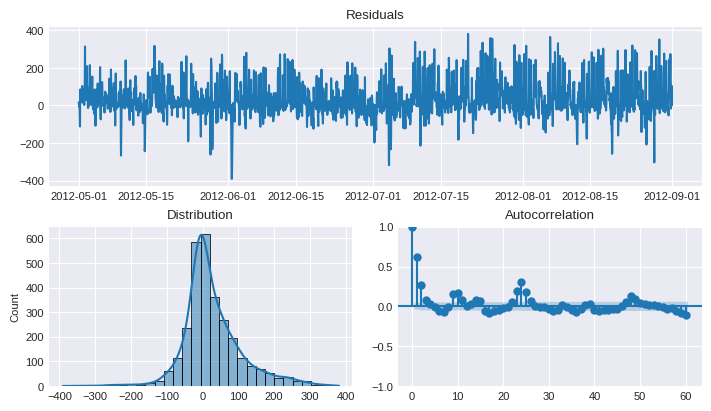

In [159]:
# Out-sample residuals distribution
# ==============================================================================
residuals = data.loc[predictions_val.index, 'users'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(
        y_true = data.loc[predictions_val.index, 'users'],
        y_pred = predictions_val['pred'],
        figsize=(7, 4)
    )

In [160]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'users'],
    y_pred = predictions_val['pred']
)

he backtesting process is then run to estimate the prediction intervals in the test set. The argument use_in_sample_residuals is set to False so that the previously stored out-sample residuals are used and use_binned_residuals so that the residuals used in bootstrapping are selected conditional on the range of prediction values.


In [161]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))
metric, predictions = backtesting_forecaster(
   forecaster              = forecaster,
   y                       = data['users'],
   exog                    = data[exog_features],
   cv                      = cv,
   metric                  = 'mean_absolute_error',
   interval                = [5, 95],  # 90% prediction interval
   interval_method         = 'conformal',
   use_in_sample_residuals = False,  # Use out-sample residuals
   use_binned_residuals    = True,   # Use residuals conditioned on predicted values
)
predictions.head(5)

100%|██████████| 80/80 [00:01<00:00, 67.34it/s]


pred  lower_bound  upper_bound
2012-09-01 00:00:00  146.284845    63.988690   228.580999
2012-09-01 01:00:00  114.371326    32.075171   196.667480
2012-09-01 02:00:00   79.036892    42.194878   115.878907
2012-09-01 03:00:00   43.980475     7.138460    80.822489
2012-09-01 04:00:00   24.390378     9.744150    39.036607

In [162]:
# Plot prediction intervals vs real value
# ==============================================================================
fig = go.Figure([
    go.Scatter(name='Prediction', x=predictions.index, y=predictions['pred'], mode='lines'),
    go.Scatter(
        name='Real value', x=data_test.index, y=data_test['users'], mode='lines',
    ),
    go.Scatter(
        name='Upper Bound', x=predictions.index, y=predictions['upper_bound'], mode='lines',
        marker=dict(color="#444"), line=dict(width=0), showlegend=False
    ),
    go.Scatter(
        name='Lower Bound', x=predictions.index, y=predictions['lower_bound'], marker=dict(color="#444"),
        line=dict(width=0), mode='lines', fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
    )
])
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="users",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001),
    # Initial zoom on x axis betwee 1 oct to 10 oct
    xaxis=dict(range=['2012-10-01', '2012-10-10'])
)
fig.show()

In [163]:
# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
              y_true       = data.loc[end_validation:, "users"],
              lower_bound  = predictions["lower_bound"],
              upper_bound  = predictions["upper_bound"]
            )
area = (predictions['upper_bound'] - predictions['lower_bound']).sum()
print(f"Total area of the interval: {round(area, 2)}")
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

Total area of the interval: 625416.3
Predicted interval coverage: 88.99 %


The observed coverage in the test set is slightly lower than the theoretically expected coverage (90%). This means that they contain the true value with a lower probability than expected.



## Choosing the best model

In [211]:
# Register the model in MLflow
client = MlflowClient()
experiment = client.get_experiment_by_name("skforecast_experiment")
# Retrieve all run from experiment
# Retrieve all runs from the experiment
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="",
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,
    max_results=1000
)

In [212]:
# Convert runs to DataFrame
runs_df = pd.DataFrame([run.data.metrics for run in runs])

# Add run IDs to the DataFrame
runs_df['run_id'] = [run.info.run_id for run in runs]

# Sort by MAE to find the best run
best_run = runs_df.sort_values(by='mae').iloc[0]
best_run_id = best_run['run_id']


In [213]:
run = client.get_run(best_run_id)
params = run.data.params
tags = run.data.tags
metrics = run.data.metrics
# Print the best run details
print(f"Best run ID: {best_run_id}")
print(f"Parameters: {params}")
print(f"Tags: {tags}")
print(f"Metrics: {metrics}")

Best run ID: 4d28c1188a344f578c98d7bb2d5b0b98
Parameters: {'regressor': 'LGBMRegressor', 'window_sizes': '72', 'lags': '[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24\n 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48\n 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]', 'regressor_params': "{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}"}
Tags: {'model_type': 'Recursive', 'regressor': 'LGBMRegressor', 'mlflow.source.name': '/home/nhatquang/anaconda3/envs/fsds-env/lib/python3.10/site-packages/ipykernel_launcher.py', 'mlflow.user': 'nhatq

In [223]:
!mlflow artifacts download -r "187db747f4ad45538d04db59f1a299a2" -a skforecast_model/recursive -d ../src/api/


/home/nhatquang/demandForecasting/src/api/skforecast_model/recursive


In [224]:
model_config = {
    "params": params,
    "tags": tags,
    "metrics": metrics,
}
with open("../src/api/skforecast_model/recursive/model_config.json", "w") as f:
    json.dump(model_config, f, indent=4)

# Explainability
This technique aim to demystify these models, providing insight into their inner workings and helping to build trust, transpaency and meet requirement from various domain.

In [164]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(**best_params),
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)
forecaster.fit(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features]
)


Prefer using SHAP.

In [165]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = data.loc[:end_validation, 'users'],
                       exog = data.loc[:end_validation, exog_features]
                   )
display(X_train.head(3))
display(y_train.head(3))

lag_1  lag_2  lag_3  lag_23  lag_24  lag_25  lag_167  \
date_time                                                                   
2011-01-22 01:00:00   13.0   27.0   34.0     2.0     6.0    21.0     12.0   
2011-01-22 02:00:00   12.0   13.0   27.0     1.0     2.0     6.0      8.0   
2011-01-22 03:00:00   11.0   12.0   13.0     1.0     1.0     2.0      5.0   

                     lag_168  lag_169  roll_mean_72  ...  \
date_time                                            ...   
2011-01-22 01:00:00     20.0     28.0     71.291667  ...   
2011-01-22 02:00:00     12.0     20.0     71.361111  ...   
2011-01-22 03:00:00      8.0     12.0     71.472222  ...   

                    poly_hour_sin__sunset_hour_cos  \
date_time                                            
2011-01-22 01:00:00                      -0.066987   
2011-01-22 02:00:00                      -0.129410   
2011-01-22 03:00:00                      -0.183013   

                     poly_hour_cos__sunrise_hour_sin  \
date_time                                              
2011-01-22 01:00:00                         0.933013   
2011-01-22 02:00:00                         0.836516   
2011-01-22 03:00:00                         0.683013   

                     poly_hour_cos__sunrise_hour_cos  \
date_time                                              
2011-01-22 01:00:00                        -0.250000   
2011-01-22 02:00:00                        -0.224144   
2011-01-22 03:00:00                        -0.183013   

                     poly_hour_cos__sunset_hour_sin  temp_window_1D_mean  \
date_time                                                                  
2011-01-22 01:00:00                       -0.933013             6.935833   
2011-01-22 02:00:00                       -0.836516             6.594167   
2011-01-22 03:00:00                       -0.683013             6.252500   

                     temp_window_1D_max  temp_window_1D_min  \
date_time                                                     
2011-01-22 01:00:00                9.84                1.64   
2011-01-22 02:00:00                9.84                1.64   
2011-01-22 03:00:00                9.84                1.64   

                     temp_window_7D_mean  temp_window_7D_min  temp  
date_time                                                           
2011-01-22 01:00:00             9.088333                1.64  1.64  
2011-01-22 02:00:00             9.059048                1.64  1.64  
2011-01-22 03:00:00             9.029762                1.64  1.64  

[3 rows x 62 columns]

date_time
2011-01-22 01:00:00    12.0
2011-01-22 02:00:00    11.0
2011-01-22 03:00:00     7.0
Freq: h, Name: y, dtype: float32

In [166]:
# Create SHAP explainer (for three base models)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)

# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

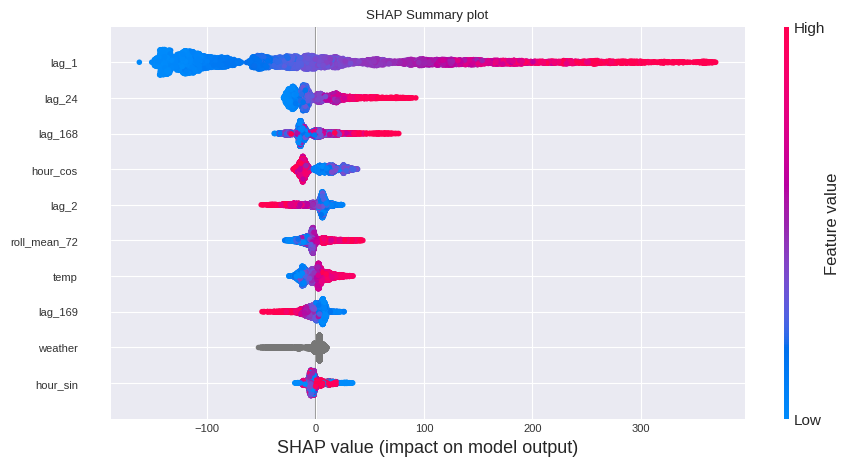

In [167]:
# Shap summary plot (top 10)
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(10, 4.5)

In [168]:
type(forecaster.regressor).__name__

'LGBMRegressor'